# Generating data with the prior/posterior distribution

Visualizing the distribution of the prior can help to manually choose a better prior (being completely uninformative is just useless). Also, visualizing the posterior distribution allows to verify if the posterior is correct or completely wrong.

Here, we will take as a model:

$T(n) = \alpha + n\times\beta |\mathcal{N}(0, \sigma^2)|$

In [1]:
import pandas
from plotnine import *
import warnings
import pystan
import matplotlib.pyplot as plt
import numpy
import statsmodels.formula.api as st
warnings.simplefilter(action='ignore', category=FutureWarning)

def generate_dataset(alpha, beta, sigma, N=1000, min_x=0, max_x=10000):
    numpy.random.seed(42)
    noise = numpy.abs(numpy.random.normal(0, sigma, N))
    size = numpy.random.randint(min_x, max_x, N)
    duration = alpha + size * (noise + beta)
    df = pandas.DataFrame(dict(size=size, duration=duration))
    return df

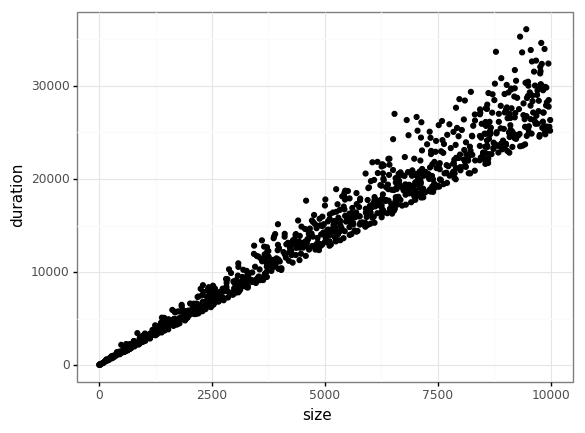

<ggplot: (-9223363290869855656)>

In [2]:
df = generate_dataset(30, 2.5, 0.5)
plot = ggplot(df, aes(x='size', y='duration')) + geom_point() + expand_limits(y=1) + theme_bw()
plot

In [3]:
from math import sqrt, pi

def halfnormal_parameters(data):
    '''
    Suppose that we have a sample of variables Y such that Y=mu+X and X~N(0, sigma).
    This function computes the value of mu and sigma.
    '''
    var = data.var()
    mean = data.mean()
    sigma = sqrt(var / (1-2/pi))
    mu = mean - sigma*sqrt(2)/sqrt(pi)
    return mu, sigma

## Naive approach

In [4]:
from math import sqrt, pi

def compute_params_naive(df, quantile=0.01):
    small_sizes = df[df['size'] < df['size'].quantile(quantile)]
    large_sizes = df[df['size'] > df['size'].quantile(1-quantile)].copy()
    intercept = small_sizes['duration'].mean()
    large_sizes['size'] -= intercept
    large_sizes['ratio'] = large_sizes['duration'] / large_sizes['size']
    mu, sigma = halfnormal_parameters(large_sizes['ratio'])
    return intercept, mu, sigma

params = compute_params_naive(df)
params

(87.52333909425856, 2.466090193814843, 0.39994469984047876)

In [5]:
def plot_fit(df, alpha, beta, sigma):
    N = len(df)
    noise = numpy.abs(numpy.random.normal(0, sigma, N))
    duration = alpha + df['size'] * (noise + beta)
    tmp = pandas.DataFrame({'size': df['size'], 'duration': duration})
    plot = ggplot(df, aes(x='size', y='duration')) + geom_point() + theme_bw() + geom_point(tmp, color='red', alpha=0.3)
    print(plot)
    print(plot + scale_x_log10() + scale_y_log10())

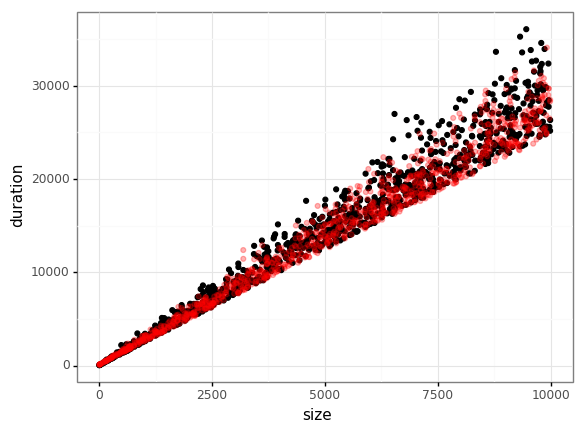

<ggplot: (8745984970907)>


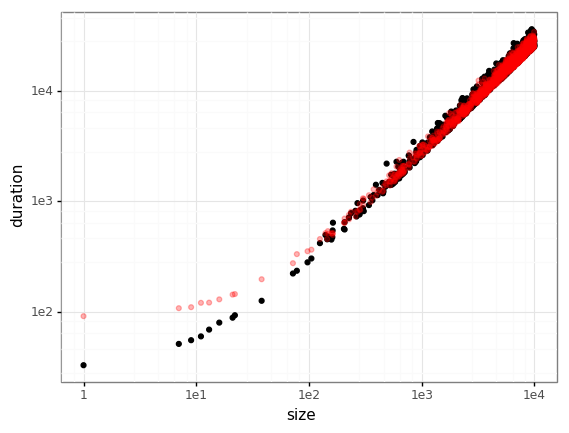

<ggplot: (-9223363290871296845)>


In [6]:
plot_fit(df, *params)

## Linear regression approach

In [7]:
def compute_params_lm(df, quantile=0.01):
    reg = st.ols(data=df, formula='duration ~ size').fit()
    coefficient = reg.params['size']
    intercept = reg.params['Intercept']
    norm_residuals = reg.resid / df['size']
    sigma = norm_residuals.std()
    return intercept, coefficient, sigma

params = compute_params_lm(df)
params

(46.93494233106144, 2.8862433204044615, 0.6285753168446309)

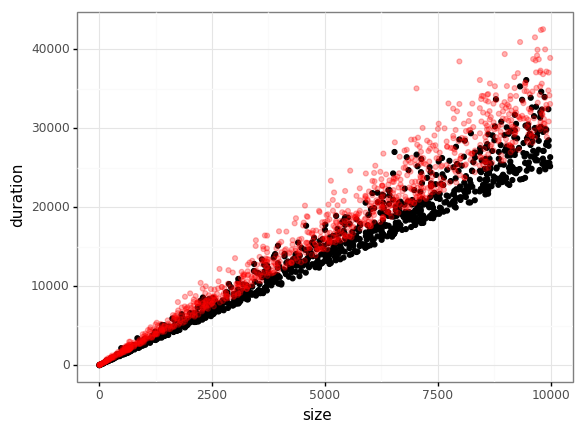

<ggplot: (8745983504427)>


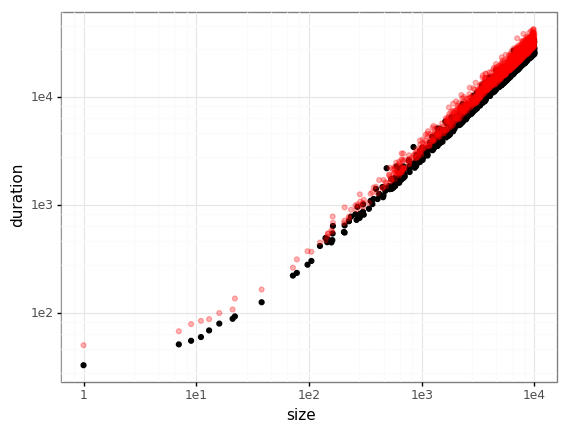

<ggplot: (8745983353485)>


In [8]:
plot_fit(df, *params)

## Bayesian approach

In [9]:
%%time

model_code = """
data {
    int<lower=1> N; // number of points
    vector[N] X; // real X[N] does not work
    vector[N] Y;
}
parameters {
    real alpha;
    real beta;
    real sigma;
}
model {
    alpha ~ normal(0, 20);
    beta ~ normal(0, 20); 
    sigma ~ normal(1, 1);
    Y ~ normal(alpha + X*beta, sigma);
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e3399037d2cfff6f6d86586f00ecb37d NOW.


CPU times: user 963 ms, sys: 45.6 ms, total: 1.01 s
Wall time: 53.1 s


Inference for Stan model: anon_model_e3399037d2cfff6f6d86586f00ecb37d.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  22.08    6.42  15.07  -1.17   1.43  26.32  33.47  45.18      6   2.14
beta    2.89  9.5e-4 2.6e-3   2.89   2.89   2.89   2.89   2.89      7   1.59
sigma 231.75    0.01   0.49 230.79 231.39 231.76  232.1 232.64   2207    1.0
lp__  -5.9e4    0.67    1.7 -5.9e4 -5.9e4 -5.9e4 -5.9e4 -5.9e4      6   1.65

Samples were drawn using NUTS at Fri Feb  1 11:09:06 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 179 ms, sys: 41.9 ms, total: 221 ms
Wall time: 9.84 s


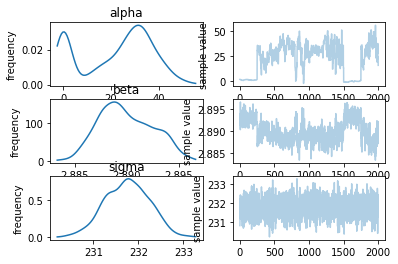

In [10]:
%%time

data=dict(N=len(df), Y=df['duration'], X=df['size'])

fit = sm.sampling(data=data, iter=500, chains=8)

print(fit)

fit.plot()

In [11]:
%%time

model_code = """
data {
    int<lower=1> N; // number of points
    vector[N] X; // real X[N] does not work
    vector[N] Y;
}
parameters {
    real alpha;
    real beta;
    real sigma;
}
model {
    alpha ~ normal(0, 20);
    beta ~ normal(0, 20); 
    sigma ~ normal(1, 1);
    Y ~ normal(alpha + X*beta, sigma*X);
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_81735d05a4eb93e0d77a79faf1d7a296 NOW.


CPU times: user 802 ms, sys: 131 ms, total: 934 ms
Wall time: 50 s


Inference for Stan model: anon_model_81735d05a4eb93e0d77a79faf1d7a296.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  29.84  6.7e-3   0.29  29.28  29.66  29.85  30.04   30.4   1852    1.0
beta    2.89  4.2e-4 9.2e-3   2.87   2.88   2.89    2.9   2.91    485   1.01
sigma    0.3  1.4e-4 6.4e-3   0.28   0.29    0.3    0.3   0.31   2119    1.0
lp__   -7477    0.04   1.18  -7480  -7478  -7477  -7476  -7476    744   1.01

Samples were drawn using NUTS at Fri Feb  1 11:09:57 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 117 ms, sys: 41.2 ms, total: 158 ms
Wall time: 1.16 s


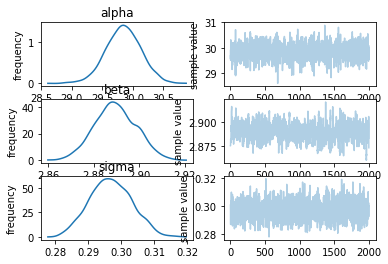

In [12]:
%%time

data=dict(N=len(df), Y=df['duration'], X=df['size'])

fit = sm.sampling(data=data, iter=500, chains=8)

print(fit)

fit.plot()

In [13]:
%%time

model_code = """
data {
    int<lower=1> N; // number of points
    vector<lower=0>[N] X; // real X[N] does not work
    vector<lower=0>[N] Y;
}
parameters {
    real<lower=0> alpha;
    real<lower=0> beta;
    real<lower=0> sigma;
}
model {
    alpha ~ normal(0, 20);
    beta ~ normal(0, 20); 
    sigma ~ normal(1, 1);
    Y ~ normal(alpha + X*beta, sigma*X);
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5514e8fa74607ab5c64ce19f22cde812 NOW.


CPU times: user 834 ms, sys: 141 ms, total: 975 ms
Wall time: 50.2 s


Inference for Stan model: anon_model_5514e8fa74607ab5c64ce19f22cde812.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  29.85  7.6e-3   0.28  29.33  29.66  29.86  30.04  30.39   1335    1.0
beta    2.89  1.7e-4 9.5e-3   2.87   2.88   2.89    2.9   2.91   2938    1.0
sigma    0.3  2.3e-4 6.9e-3   0.28   0.29    0.3    0.3   0.31    881   1.01
lp__   -7474    0.04   1.23  -7477  -7474  -7474  -7473  -7473    975    1.0

Samples were drawn using NUTS at Fri Feb  1 11:10:49 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 119 ms, sys: 43.6 ms, total: 163 ms
Wall time: 860 ms


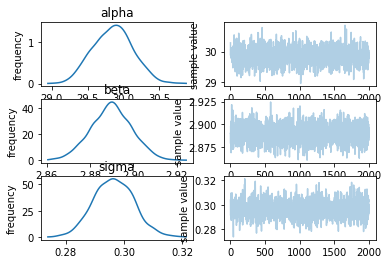

In [14]:
%%time

data=dict(N=len(df), Y=df['duration'], X=df['size'])

fit = sm.sampling(data=data, iter=500, chains=8)

print(fit)

fit.plot()

In [15]:
def get_generated_data(fit):
    fit = fit.extract()
    alpha = fit['alpha'].mean()
    beta  = fit['beta'].mean()
    sigma = fit['sigma'].mean()
    return alpha, beta, sigma

params = get_generated_data(fit)
params

(29.853164431386578, 2.889932808439543, 0.2964606907531162)

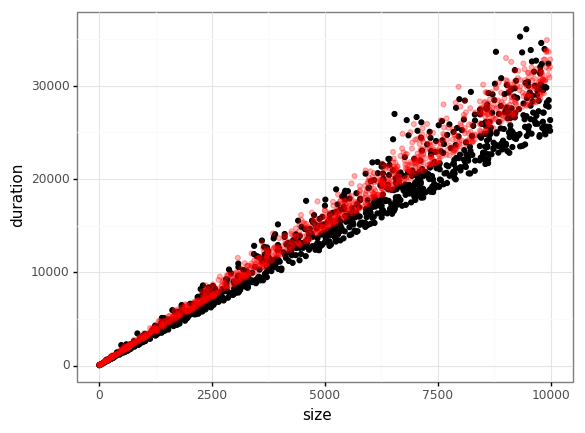

<ggplot: (-9223363290911170858)>


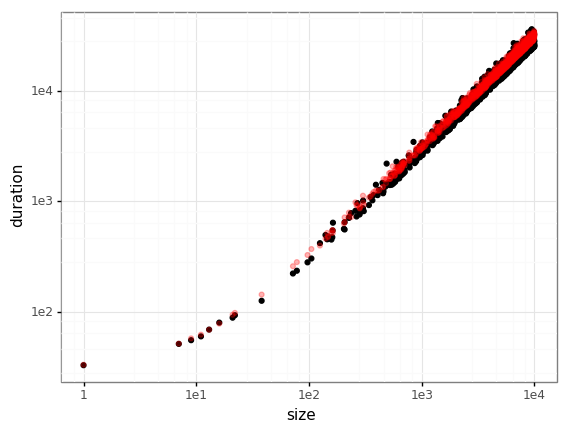

<ggplot: (-9223363290903553834)>


In [16]:
plot_fit(df, *params)

In [17]:
%%time

model_code = """
data {
    int<lower=1> N; // number of points
    vector<lower=0>[N] X; // real X[N] does not work
    vector<lower=0>[N] Y;
}
parameters {
    real<lower=0> alpha;
    real<lower=0> beta;
    real<lower=0> sigma;
}
model {
    alpha ~ normal(0, 20);
    beta ~ normal(0, 20); 
    sigma ~ normal(1, 1);
    for (i in 1:N) {
        target += abs(normal_lpdf(Y[i] | alpha + X[i]*beta, sigma*X[i])); // https://stackoverflow.com/questions/40289457/stan-using-target-syntax
    }
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d27a95961888ebb3b994b72c0d465eb8 NOW.


CPU times: user 832 ms, sys: 64.8 ms, total: 897 ms
Wall time: 49.7 s


Inference for Stan model: anon_model_d27a95961888ebb3b994b72c0d465eb8.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   7.38     3.3   6.61   0.41    1.8   5.72  12.57  19.31      4 3126.1
beta   72.32   37.28   77.7   0.13   0.47   43.8 116.27 235.04      4   8.14
sigma  11.14    6.33  12.68   0.21   0.32   5.91  23.68   31.6      4  79.99
lp__   4.9e4  6755.1  2.0e4  2.0e4  3.3e4  4.5e4  6.2e4  9.6e4      9   3.34

Samples were drawn using NUTS at Fri Feb  1 11:11:42 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 129 ms, sys: 63 ms, total: 192 ms
Wall time: 1.79 s


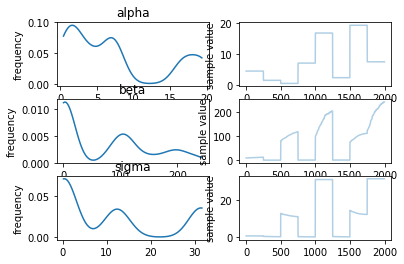

In [18]:
%%time

data=dict(N=len(df), Y=df['duration'], X=df['size'])

fit = sm.sampling(data=data, iter=500, chains=8)

print(fit)

fit.plot()

In [19]:
params = get_generated_data(fit)
params

(7.382669368858643, 72.32101277737297, 11.142472325699687)